<a href="https://colab.research.google.com/github/LamKser/FPT-ResFes-KamenRider/blob/main/Merge_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract==0.3.9
!sudo apt-get install tesseract-ocr-eng

In [ ]:
!pip install -r /content/drive/MyDrive/YOLOv7_train/yolov7/requirements.txt

In [ ]:
%cd /content/drive/MyDrive/YOLOv7_train/yolov7/pretrain
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [ ]:
# clone souce code YOLOv7 ve YOLOv7_train
%cd /content/drive/MyDrive/YOLOv7_train
!git clone https://github.com/WongKinYiu/yolov7.git

# Setting requirements


In [5]:
%cd /content/drive/MyDrive/YOLOv7_train/yolov7
import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

/content/drive/MyDrive/YOLOv7_train/yolov7


In [6]:
classes_to_filter = ['car', 'motorcycle', 'bus', 'truck']
opt  = {
    
    "weights": "pretrain/yolov7.pt.1", # Path to weights file default weights are for nano model
    "yaml"   : "data/coco.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : '',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None

}

classes_to_filter_2 = ['plate']
opt_2  = {
    
    "weights": "/content/drive/MyDrive/YOLOv7_train/save_model_fol/detected.pt", # Path to weights file default weights are for nano model
    "yaml"   : "data/mydataset.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : '',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter_2  # list of classes to filter or None

}

In [7]:
import cv2
import numpy as np
import pytesseract
from google.colab.patches import cv2_imshow
import re

In [13]:
# Detect on images
def detect_image(opt, img_r, model, device):
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    # device = select_device(opt['device'])
    half = device.type != 'cpu'
    #model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    random.seed(42)
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    img0 = img_r
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]

    # Apply NMS
    num_classes = None
    if opt['classes']:
      num_classes = []
      for class_name in opt['classes']:

        num_classes.append(names.index(class_name))

    if num_classes == None:
      
      num_classes = [i for i in range(len(names)) if i not in num_classes]

    
    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes = num_classes, agnostic= True)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
        s = ''
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
        if len(det):
          det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

          for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
        
          for *xyxy, conf, cls in reversed(det):

            label = f'{names[int(cls)]} {conf:.2f}'
            plot_one_box(xyxy, img0, color=colors[int(cls)], line_thickness=2) # , label=label
    return img0, det

In [ ]:
# Load models
device_selected = select_device('')
model_2 = attempt_load(opt_2['weights'], map_location=device_selected)
model = attempt_load(opt['weights'], map_location=device_selected)

In [10]:
# image processing for recognize
import cv2
import numpy as np

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [97]:
# Recognize image to string
def licensePlates_OCR(img):
  # img = cv2.imread(img)

  gray = get_grayscale(img)
  # rmnoise =remove_noise(gray)
  thresh = thresholding(gray)
  # openin = opening(gray)
  # cannyy = canny(thresh)
  # ero = erode(thresh)
  # dila = dilate(ero)
  # match_tem = match_template(thresh)
  cv2_imshow(thresh)

  # Adding custom options
  custom_config = r'--psm 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  text = pytesseract.image_to_string(thresh, lang='eng' ,config=custom_config)
  x = re.findall("([0-9A-Z]*)", text)
  # print(x)
  if len(x) >= 1:
    if len(x[0]) > 5:
      text = x[0]
    else:
      text = 'cannot recognize license plate'
  else:
    text = 'cannot recognize license plate'
  
  return text

In [12]:
import os, os.path

def get_name_video():  

  # path joining version for other paths
  DIR = '/content/drive/MyDrive/test_dataset/ouputs_test_videos'
  temp = str(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

  video_save = '/content/drive/MyDrive/test_dataset/ouputs_test_videos/' + temp
  return video_save

# Deployment on images


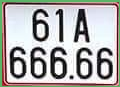

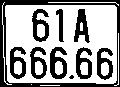

cannot recognize license plate


In [98]:
from google.colab.patches import cv2_imshow

source_image_path = '/content/drive/MyDrive/YOLOv7_train/yolov7/test_images/oto.jpg'
img_r = cv2.imread(source_image_path)

#Detect on images
img0, pl_det = detect_image(opt_2, img_r, model_2,device_selected)
original_image = img0
img0, det = detect_image(opt, img0, model, device_selected)

#Recognize on licence plates
for *xyxy, conf, cls in reversed(pl_det):
  
  x1 = int(xyxy[0].item())
  y1 = int(xyxy[1].item())
  x2 = int(xyxy[2].item())
  y2 = int(xyxy[3].item())

  confidence_score = conf
  class_index = cls

  # print('bouding box is ', x1, y1, x2, y2)
  # print('class index is ', class_index)

  cropped_frame = original_image[y1:y2, x1:x2]
  cv2_imshow(cropped_frame)
  text = licensePlates_OCR(cropped_frame)
  print(text)

# Deployment on videos


In [ ]:
video = cv2.VideoCapture('/content/drive/MyDrive/test_dataset/test-videos/test_3.mp4')

nameOfvideo = get_name_video() + '.mp4'
recording = False

#Video information
fps = video.get(cv2.CAP_PROP_FPS)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialzing object for writing video output
if recording is False:
  output = cv2.VideoWriter(nameOfvideo, cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
  torch.cuda.empty_cache()
  recording = True

for j in range(nframes):
  ret, img0 = video.read()

  cv2.putText(img0, str(int(fps)), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

  if ret:
    #Detect
    img0, det_pl = detect_image(opt_2, img0, model_2, device_selected)
    original_image = img0
    img0, det_ve = detect_image(opt, img0, model, device_selected)
    
    #Recognize
    for *xyxy, conf, cls in reversed(det_pl):
  
      x1 = int(xyxy[0].item())
      y1 = int(xyxy[1].item())
      x2 = int(xyxy[2].item())
      y2 = int(xyxy[3].item())

      confidence_score = conf
      class_index = cls

      # print('bouding box is ', x1, y1, x2, y2)
      # print('class index is ', class_index)

      cropped_frame = original_image[y1-5:y2+5, x1-5:x2+5]
      text = licensePlates_OCR(cropped_frame)
      

    print(f"{j+1}/{nframes} frames processed")

    if recording:
      output.write(img0)
  else:
    break

if recording:
  output.release()
  video.release()